## Importing libs and setting plotting parameters

In [1]:
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mp
import numpy as np
import pandas as pd

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.ml_functions import *
from utils.process_data import *

mp.style.use('ggplot')
mp.rcParams['font.family'] = "serif"
mp.rcParams['font.size'] = 20
sns.set(style="darkgrid", font_scale=1.5)

In [2]:
df_train = pd.read_parquet("../data/raw/train.parquet")
df_test = pd.read_parquet("../data/raw/test.parquet")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2889113 entries, 3281 to 29337019
Data columns (total 14 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id                            float64       
 1   desembolso                    datetime64[ns]
 2   vencimento                    datetime64[ns]
 3   valor_emprestado              float64       
 4   pgto_diario_esperado          float64       
 5   dia                           datetime64[ns]
 6   dias_pos_desembolso           float64       
 7   divida_total                  float64       
 8   divida_principal              float64       
 9   pagamento_diario              float64       
 10  amortizacao_principal_diario  float64       
 11  transacionado                 float64       
 12  subsegmento                   object        
 13  y                             float64       
dtypes: datetime64[ns](3), float64(10), object(1)
memory usage: 330.6+ MB


In [4]:
df_train.head()

,id,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento,y
3281,6.0,2019-03-25,2019-12-26,7100.0,33.7107,2019-03-25,0.0,7197.98,7100.0,0.00,0.0,664.0,None,0.0
3282,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-26,1.0,7212.25,7100.0,0.00,0.0,0.0,None,0.0
3283,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-27,2.0,7226.54,7100.0,0.00,0.0,150.0,None,0.0
3284,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-28,3.0,7207.22,7100.0,33.64,0.0,0.0,None,0.0
3285,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-29,4.0,7221.51,7100.0,0.00,0.0,0.0,None,0.0


## Changing types of train data

## 0. Data Cleansy

### Following the directions given in the clarification email sent by topminds stone (it is available in body text of the file `clarification_email.txt`), the predictions must be made in the 90th day after the loan. So, to avoid target leakage, all rows with information about the days after the 90th day are deleted.

In [5]:
def data_cleanse(df):
    #deleting rows in the raw data
    df.drop(index=df.index[df['dias_pos_desembolso'] > 89], inplace=True)
    df.reset_index(drop=True, inplace=True) 
    return df

df_train = data_cleanse(df_train)
df_test = data_cleanse(df_test)  
    
# #deleting rows in the raw data
# df.drop(index=df.index[df['dias_pos_desembolso'] > 89], inplace=True)
# df.reset_index(drop=True, inplace=True)

# #deleting rows in dict_loans_timeseries_attributes
# for index, tmp_df_timeseries in dict_dfs_timeseries.items():
#     tmp_df_timeseries.drop(index=tmp_df_timeseries.index[tmp_df_timeseries['dias_pos_desembolso'] > 89], inplace=True)
#     tmp_df_timeseries.reset_index(drop=True, inplace=True)    

In [6]:
#setting proper types
dtypes = {
    'id': int,
    'dias_pos_desembolso': int,
}

df_test = df_test.astype(dtypes) 

df_train = df_train.astype(dtypes) 
df_train['y'] = df_train['y'].astype(int)

In [7]:
# Extracting a daframe with just the constant attributes
    df, constant_attributes, id_column_name="id"
):

    unique_index = df[id_column_name].unique()
    unique_index.sort()

    df_constant_attributes = pd.DataFrame(
        columns=constant_attributes, index=unique_index.astype(int)
    )

    company_ids_in_df = df[id_column_name].to_numpy()

    for idx in unique_index:
        idx_boolean_list = company_ids_in_df == idx
        tmp_df = df.loc[idx_boolean_list]
        df_constant_attributes.loc[idx] = tmp_df[constant_attributes].iloc[-1]

    return df_constant_attributes


constant_attributes = ['desembolso', 'vencimento', 'valor_emprestado', 'pgto_diario_esperado', 'subsegmento', 'y']

df_train_constant = from_sorted_df_get_constant_attributes(df_train, constant_attributes)
df_test_constant = from_sorted_df_get_constant_attributes(df_test, constant_attributes[:-1])

In [12]:
df_train_constant.head()

,valor_emprestado,pgto_diario_esperado,subsegmento,y,duracao_esperada
6,7100.0,33.8852,None,0,276
8,6900.0,32.9307,None,0,276
9,42500.0,175.5301,None,0,276
11,4200.0,19.2553,Alimentação Rápida,0,276
12,7700.0,34.0856,Bares e Restaurantes,0,274


In [9]:
# From datetime to days
def from_date_to_days(df):
    df["desembolso"] = pd.to_datetime(
        df["desembolso"], format="%Y-%m-%d")
    df["vencimento"] = pd.to_datetime(
        df["vencimento"], format="%Y-%m-%d")
    
    df['duracao_esperada'] = (df.vencimento - df.desembolso).dt.days
    
    df.drop(columns=['desembolso', 'vencimento'], inplace=True)
    
    return df

df_train_constant = from_date_to_days(df_train_constant)
df_test_constant = from_date_to_days(df_test_constant)

In [11]:
df_train_constant.head()

,valor_emprestado,pgto_diario_esperado,subsegmento,y,duracao_esperada
6,7100.0,33.8852,None,0,276
8,6900.0,32.9307,None,0,276
9,42500.0,175.5301,None,0,276
11,4200.0,19.2553,Alimentação Rápida,0,276
12,7700.0,34.0856,Bares e Restaurantes,0,274


In [14]:
drop_columns = ['desembolso', 'vencimento', 'valor_emprestado', 'pgto_diario_esperado', 'dia']

df_train.drop(columns = drop_columns, inplace=True)
df_test.drop(columns = drop_columns, inplace=True)

In [15]:
df_train.head()

,id,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento,y
0,6,0,7197.98,7100.0,0.00,0.0,664.0,None,0
1,6,1,7212.25,7100.0,0.00,0.0,0.0,None,0
2,6,2,7226.54,7100.0,0.00,0.0,150.0,None,0
3,6,3,7207.22,7100.0,33.64,0.0,0.0,None,0
4,6,4,7221.51,7100.0,0.00,0.0,0.0,None,0


## 1. Data Normalization

### The following steps of Data Normalization will use the Timeseries attributes ( `divida_total`, `divida_principal`, `pagamento_diario`, `amortizacao_principal_diario`, `transacionado` ). Thus to enforce some comparative bias between these value, they will be normalized according to `valor_emprestado`.

In [17]:
def data_normalization(df, df_constant):
    # Getting the numpy array to improve performance
    timeseries_attributes = ['divida_total', 'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario', 'transacionado']
    df_timeseries_array = df[timeseries_attributes].values

    #this loop takes approx. 1.5 min to run
    for loan_index in df_constant.index:
        loan_value = df_constant.loc[loan_index, 'valor_emprestado']
        loan_index_in_array = df.index[df['id'].isin([loan_index])]

        df_timeseries_array[loan_index_in_array, :] /= loan_value

    df[timeseries_attributes] = df_timeseries_array
    
    return df
    
df_train_norm = data_normalization(df_train, df_train_constant)
df_test_norm = data_normalization(df_test, df_test_constant)

In [19]:
df_test_norm.head()

,id,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento
0,7,0,1.013800,1.0,0.000000,0.0,0.000000,Calçados
1,7,1,1.014837,1.0,0.000000,0.0,0.000000,Calçados
2,7,2,1.015876,1.0,0.000000,0.0,0.069565,Calçados
3,7,3,1.003289,1.0,0.013626,0.0,0.021739,Calçados
4,7,4,1.004317,1.0,0.000000,0.0,0.049304,Calçados


## 2. Feature Engineering

### Here I am creating 8 variables by aggregating the timeseries attributes into a single dataframe:
#### pagamento_diario_total is the summation of the daily registered payment
#### amortizacao_diario_total is the summation of the daily registered amortization
#### transacao_diaria_total is the summation of the daily registered transactions
#### divida_total_menos_principal_area is the approximated area of curve made by the data points of divida_total - divida_principal

In [202]:
df_values[:,0]

array([6.0000e+00, 6.0000e+00, 6.0000e+00, ..., 5.9443e+04, 5.9443e+04,
       5.9443e+04])

In [23]:
from sklearn.linear_model import LinearRegression

def aggregate_timeseries(df, df_constant_new):

    timeseries_attributes = ['divida_total', 'divida_principal',
        'pagamento_diario', 'amortizacao_principal_diario', 'transacionado']

    new_attributes = ['pagamento_diario_total',
                      'amortizacao_diario_total',
                      'transacao_diaria_total',
                      'divida_total_menos_principal_area',
                      'divida_total_variacao',
                      'angulo_esperado_decaimento_divida',
                      'angulo_fittado_decaimento_divida',
                      'score_do_fit']

    df_values = df[['id'] + timeseries_attributes].values

    linear_regression = LinearRegression()

    df_constant_new[new_attributes] = 0

    for loan_index in df_constant_new.index:
        tmp_loan_constant = df_constant_new.loc[loan_index]
        df_values_index = df_values[:,0] == loan_index
        tmp_loan_timeseries = df_values[df_values_index, 1:]

        tmp_summed_daily_payment = sum(tmp_loan_timeseries[:, 2])
        tmp_summed_daily_amortization = sum(tmp_loan_timeseries[:, 3])
        tmp_summed_daily_transaction = sum(tmp_loan_timeseries[:, 4])

        tmp_total_minus_main_debt_area = np.trapz(
            tmp_loan_timeseries[:, 0]-tmp_loan_timeseries[:, 1])

        # if positive the debt decrease
        tmp_total_debt_variation = tmp_loan_timeseries[0, 0] - tmp_loan_timeseries[-1, 0]

        tmp_expected_slope_of_debt_payment = np.arctan(
            (tmp_loan_timeseries[:, 1].max() * 100) / tmp_loan_constant['duracao_esperada'])
        tmp_expected_slope_of_debt_payment += np.pi / 2

        y = tmp_loan_timeseries[:, 0] * 100
        X = np.arange(0, y.size).reshape(y.size, 1)
        reg = linear_regression.fit(X, y)

        tmp_tg_theta = (reg.intercept_ - (reg.intercept_ +
                    reg.coef_[0]*X.flatten().max())) / (X.flatten().max())

        tmp_fitted_slope_of_debt_payment = np.arctan(tmp_tg_theta)
        tmp_fitted_slope_of_debt_payment += np.pi / 2

        tmp_linear_regression_score = reg.score(X, y)

        df_constant_new.loc[loan_index, new_attributes] =[tmp_summed_daily_payment,
                                                          tmp_summed_daily_amortization,
                                                          tmp_summed_daily_transaction,
                                                          tmp_total_minus_main_debt_area,
                                                          tmp_total_debt_variation,
                                                          tmp_expected_slope_of_debt_payment,
                                                          tmp_fitted_slope_of_debt_payment,
                                                          tmp_linear_regression_score]


    return df_constant_new


df_train_new = aggregate_timeseries(df_train_norm, df_train_constant)
df_test_new = aggregate_timeseries(df_test_norm, df_test_constant)

<ipython-input-23-e4cb13fdb108>:46: RuntimeWarning: invalid value encountered in double_scalars
  tmp_tg_theta = (reg.intercept_ - (reg.intercept_ +
/home/rmcfe/Documents/Projects/stone-data-challenge/venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [26]:
df_train_new.head()

,valor_emprestado,pgto_diario_esperado,subsegmento,y,duracao_esperada,pagamento_diario_total,amortizacao_diario_total,transacao_diaria_total,divida_total_menos_principal_area,divida_total_variacao,angulo_esperado_decaimento_divida,angulo_fittado_decaimento_divida,score_do_fit
6,7100.0,33.8852,None,0,276,0.218320,0.029133,2.647324,1.927437,0.038654,1.918403,1.628024,0.534918
8,6900.0,32.9307,None,0,276,0.830951,0.684164,0.000000,0.129382,0.697339,1.918403,2.232980,0.952861
9,42500.0,175.5301,None,0,276,0.361244,0.280656,2.116819,0.090723,0.293834,1.918403,1.909969,0.990862
11,4200.0,19.2553,Alimentação Rápida,0,276,0.249381,0.090493,1.525179,0.612338,0.102779,1.918403,1.665559,0.709418
12,7700.0,34.0856,Bares e Restaurantes,0,274,0.728260,0.621891,10.578831,0.125711,0.635717,1.920739,2.205745,0.967388


In [27]:
df_train_new.describe()

,duracao_esperada,pagamento_diario_total,amortizacao_diario_total,transacao_diaria_total,divida_total_menos_principal_area,divida_total_variacao,angulo_esperado_decaimento_divida,angulo_fittado_decaimento_divida,score_do_fit
count,17344.000000,17344.000000,17344.000000,17344.000000,17344.000000,17344.000000,17344.000000,17343.000000,1.734300e+04
mean,339.372578,0.662844,0.540634,6.391383,0.575103,0.539901,1.875267,2.122860,8.915043e-01
std,96.948017,0.301544,0.310557,17.794066,1.473642,0.326183,0.069356,0.339136,1.841448e-01
min,178.000000,-0.009388,-0.044610,-4.007810,-0.028853,-0.299752,1.726271,1.216824,4.787675e-07
25%,271.000000,0.438661,0.291658,2.209623,0.074671,0.294672,1.788528,1.897603,8.973398e-01
50%,273.000000,0.645662,0.507402,4.672755,0.132486,0.515295,1.921918,2.105875,9.622659e-01
75%,452.000000,0.950830,0.841957,7.971127,0.333803,0.848990,1.924300,2.357160,9.843781e-01
max,638.000000,1.264792,0.999971,1604.344400,13.992331,1.013771,2.082652,3.130812,1.000000e+00


#### From the graphs above, clearly some of the new attributes have a boolean behaviour, other have a bin type characteristic, and others are too much skewed. They will be transformed accordinly

## 2. Data Transformation

In [22]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

df_constant_transformed = df_constant_new.copy()

In [23]:
# transacao_diaria_total, score_do_fit, pagamento_diario_total, amortizacao_diario_total,divida_total_variacao, angulo_esperado_decaimento_divida  must be binned
# angulo_fittado_decaimento_divida standardScaler

### 2.1 Binning pagamento_diario_total,  amortizacao_diario_total, transacao_diaria_total, divida_total_variacao, angulo_esperado_decaimento_divida, score_do_fit

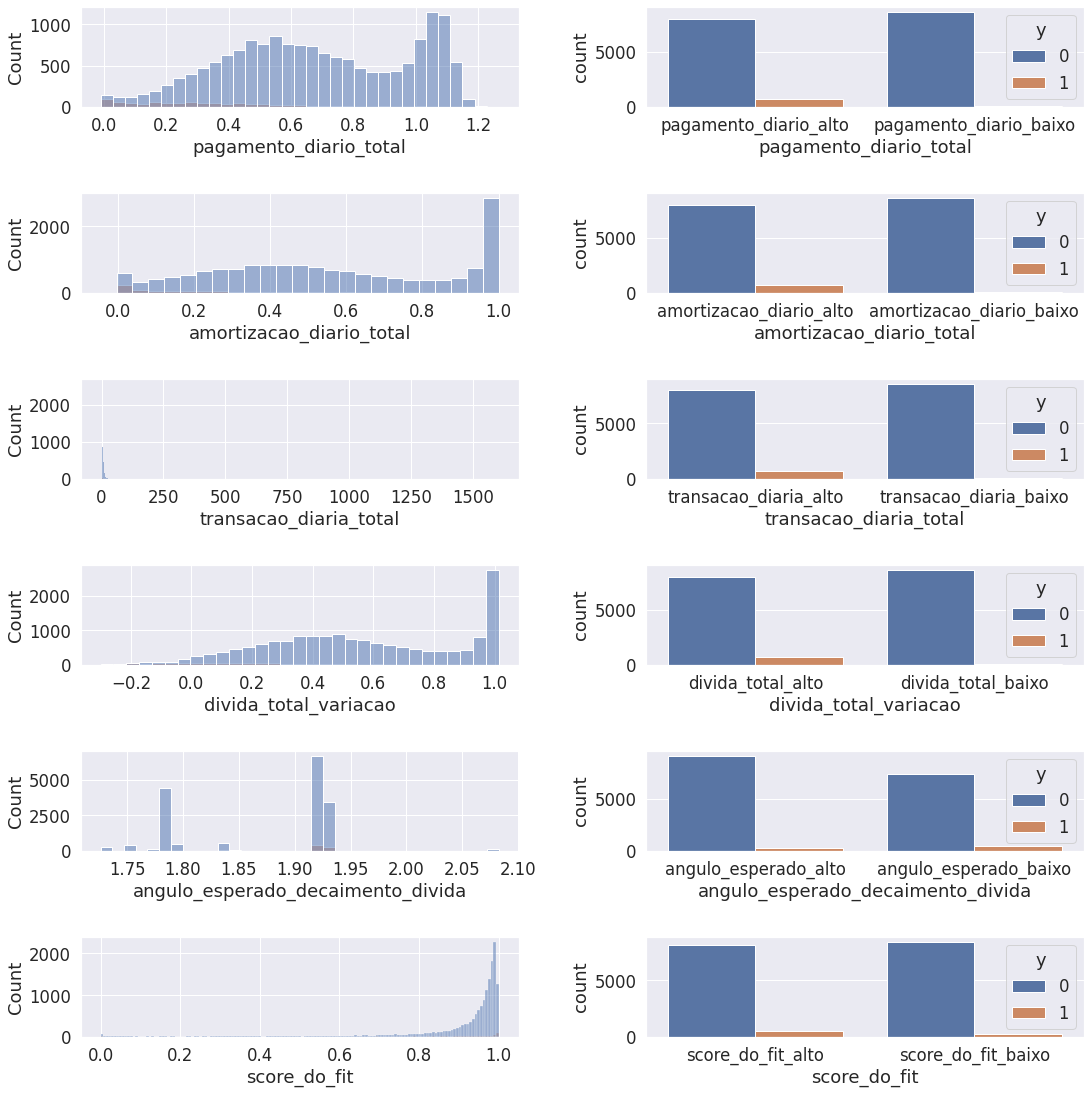

In [24]:
binned_columns = ['pagamento_diario_total', 'amortizacao_diario_total',
                 'transacao_diaria_total', 'divida_total_variacao', 'angulo_esperado_decaimento_divida', 'score_do_fit']

df_constant_transformed['pagamento_diario_total'] = pd.qcut(df_constant_new['pagamento_diario_total'], 2, labels=[
                                          'pagamento_diario_alto', 'pagamento_diario_baixo'])
df_constant_transformed['amortizacao_diario_total'] = pd.qcut(df_constant_new['amortizacao_diario_total'], 2, labels=[
                                            'amortizacao_diario_alto', 'amortizacao_diario_baixo'])
df_constant_transformed['transacao_diaria_total'] = pd.qcut(df_constant_new['transacao_diaria_total'], 2, labels=[
                                          'transacao_diaria_alto', 'transacao_diaria_baixo'])
df_constant_transformed['divida_total_variacao'] = pd.qcut(df_constant_new['divida_total_variacao'], 2, labels=[
                                         'divida_total_alto', 'divida_total_baixo'])
df_constant_transformed['angulo_esperado_decaimento_divida'] = pd.qcut(df_constant_new['angulo_esperado_decaimento_divida'], 2, labels=[
                                                     'angulo_esperado_alto', 'angulo_esperado_baixo'])
df_constant_transformed['score_do_fit'] = pd.qcut(df_constant_new['score_do_fit'], 2, labels=[
                                'score_do_fit_alto', 'score_do_fit_baixo'])

fig, ax = plt.subplots(nrows=len(binned_columns), ncols=2, figsize=(16, 16))

for i in range(len(binned_columns)): 
    sns.histplot(ax=ax[i,0], data=df_constant_new,
                 x=binned_columns[i], hue='y')
    sns.countplot(ax=ax[i,1], data=df_constant_transformed, x=binned_columns[i], hue='y')
    ax[i, 0].get_legend().remove()
    
fig.tight_layout(pad=2)

In [25]:
df_constant_transformed.head()

,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,subsegmento,y,duracao_esperada,pagamento_diario_total,amortizacao_diario_total,transacao_diaria_total,divida_total_menos_principal_area,divida_total_variacao,angulo_esperado_decaimento_divida,angulo_fittado_decaimento_divida,score_do_fit
id,,,,,,,,,,,,,,,
6,2019-03-25,2019-12-26,7100.0,33.8852,N/A,0,276,pagamento_diario_alto,amortizacao_diario_alto,transacao_diaria_alto,1.927437,divida_total_alto,angulo_esperado_alto,1.628024,score_do_fit_alto
8,2019-03-25,2019-12-26,6900.0,32.9307,N/A,0,276,pagamento_diario_baixo,amortizacao_diario_baixo,transacao_diaria_alto,0.129382,divida_total_baixo,angulo_esperado_alto,2.232980,score_do_fit_alto
9,2019-03-25,2019-12-26,42500.0,175.5301,N/A,0,276,pagamento_diario_alto,amortizacao_diario_alto,transacao_diaria_alto,0.090723,divida_total_alto,angulo_esperado_alto,1.909969,score_do_fit_baixo
11,2019-03-25,2019-12-26,4200.0,19.2553,Alimentação Rápida,0,276,pagamento_diario_alto,amortizacao_diario_alto,transacao_diaria_alto,0.612338,divida_total_alto,angulo_esperado_alto,1.665559,score_do_fit_alto
12,2019-03-06,2019-12-05,7700.0,34.0856,Bares e Restaurantes,0,274,pagamento_diario_baixo,amortizacao_diario_baixo,transacao_diaria_baixo,0.125711,divida_total_baixo,angulo_esperado_alto,2.205745,score_do_fit_baixo


### 2.2 Power Transform - divida_total_menos_principal_area

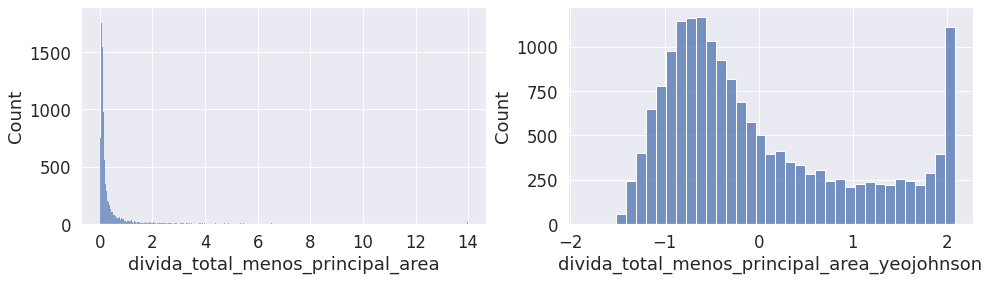

In [26]:
df_constant_transformed['divida_total_menos_principal_area_yeojohnson'] = PowerTransformer().fit_transform(df_constant_new['divida_total_menos_principal_area'].values.reshape(-1,1))

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
sns.histplot(ax=ax[0], data=df_constant_new['divida_total_menos_principal_area'])
sns.histplot(ax=ax[1], data=df_constant_transformed['divida_total_menos_principal_area_yeojohnson'])

df_constant_transformed.drop(columns=['divida_total_menos_principal_area'], inplace=True)

### 2.3 Power Transform - valor_emprestado

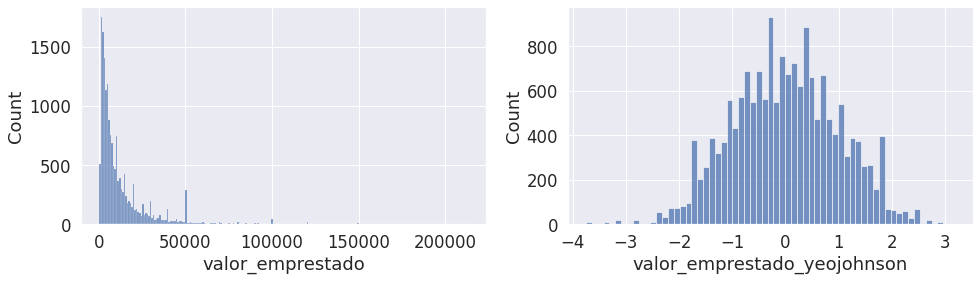

In [61]:
df_constant_transformed['valor_emprestado_yeojohnson'] = PowerTransformer().fit_transform(df_constant_new['valor_emprestado'].values.reshape(-1,1))

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
sns.histplot(ax=ax[0], data=df_constant_new['valor_emprestado'])
sns.histplot(ax=ax[1], data=df_constant_transformed['valor_emprestado_yeojohnson'])

df_constant_transformed.drop(columns=['valor_emprestado'], inplace=True)

### 2.4 Power Transform - pgto_diario_esperado

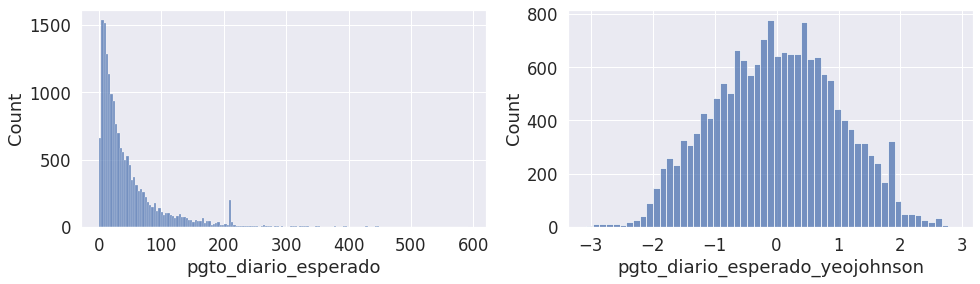

In [62]:
df_constant_transformed['pgto_diario_esperado_yeojohnson'] = PowerTransformer().fit_transform(df_constant_new['pgto_diario_esperado'].values.reshape(-1,1))

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
sns.histplot(ax=ax[0], data=df_constant_new['pgto_diario_esperado'])
sns.histplot(ax=ax[1], data=df_constant_transformed['pgto_diario_esperado_yeojohnson'])

df_constant_transformed.drop(columns=['pgto_diario_esperado'], inplace=True)

### 2.5 Mapping specifc subsegments into broader comercial sectors

In [63]:
sectors = {
    'Alimentacao e Bebida': ['Comércio de Alimentos', 'Alimentação Rápida', 'Bares e Restaurantes', 'Comércio de Bebidas', 'Supermercados'],
    'Moda e Esports': ['Vestuário', 'Calçados', 'Artigos Esportivos', 'Acessórios, Bolsas e Bijuterias'],
    'Industria, Construcao e Veiculos': ['Materiais de Construção', 'Autopeças e Acessórios', 'Comércio de Veículos', 'Gás GLP, Lubrificantes e Outros', 'Reformas e Obras em Geral', 'Postos de Gasolina', 'Estacionamentos e Lava-rápidos', 'Equipamentos de Uso Comercial e Industrial', 'Locação de Veículos'],
    'Servicos': ['Oficinas Automotivas', 'Salão de Beleza', 'Conserto de Produtos e Reparos de Peças', 'Outros Serviços - Outros', 'Delivery e Entrega', 'Telecomunicações', 'Academias e Clubes', 'Clinicas de Estética e Massagem', 'Associação', 'Cias Aéreas', 'Jornais e Revistas - Conteúdo Físico', 'Serviços Corporativos - Outros', 'Hotéis / Resorts / Pousadas / Motéis', 'Festas e Eventos', 'Gráfica, Impressão e Xerox', 'Entretenimento e Turismo', 'Consultorias', 'Logística e Mobilidade - Outros', 'Marketing', 'Serviços Imobiliários', 'Segurança', 'Táxi/Carona', 'Paisagismo e Jardinagem', 'Serviços Financeiros', 'Casa e Decoração - Outros'],
    'Saude': ['Óticas e Óculos', 'Drogarias e Farmácias', 'Outros Serviços de Saúde', 'Odontologia', 'Veterinários', 'Médicina', 'Outros Produtos de Saúde e Beleza', 'Hospitais e Laboratórios'],
    'Comercio': ['Móveis', 'Outros Comércios - Outros', 'Eletrodomésticos', 'Armarinhos e Tecido', 'Tabacaria', 'Cama, Mesa e Banho', 'Cosméticos e Perfumaria', 'Loja de Presentes','Lojas de Departamento', 'Jogos e Brinquedos Físicos', 'Joalherias, Relojoarias e Pratarias', 'Floricultura', 'Petshops', 'Artigos Religiosos e Antiguidades', 'Artigos de Decoração', 'Instrumentos Musicais, CDs, DVDs e Outros'],
    'Educacao': ['Extracurriculares, Autoescola e Outros', 'Ensino Básico', 'Livrarias e Papelarias', 'Ensino Superior e Técnico'],
    'Informatica': ['Eletrônicos', 'Softwares e Eletrônica Integrada']
}

# checking if all subsegments have been considered. The code below should only generate an N / A text output.
flat_list = [item for sublist in list(sectors.values()) for item in sublist]
for segment in df_constant_transformed['subsegmento'].unique():
    if not flat_list.count(segment):
        print(segment)
        
df_constant_transformed['segmento'] = df_constant_transformed['subsegmento'].map(lambda segment: return_key_if_contains_value(sectors, segment))
df_constant_transformed['segmento'] = df_constant_transformed['segmento'].fillna('N/A')
df_constant_transformed['segmento'] = df_constant_transformed['segmento'].astype('category')

df_constant_transformed.drop(columns=['subsegmento'], inplace=True)

KeyError: 'subsegmento'

In [37]:
# Dropping columns there were transformed or that are not going to be used in the ml models
df_constant_transformed.drop(columns=['desembolso', 'vencimento', 'duracao_esperada'], inplace=True)

<AxesSubplot:>

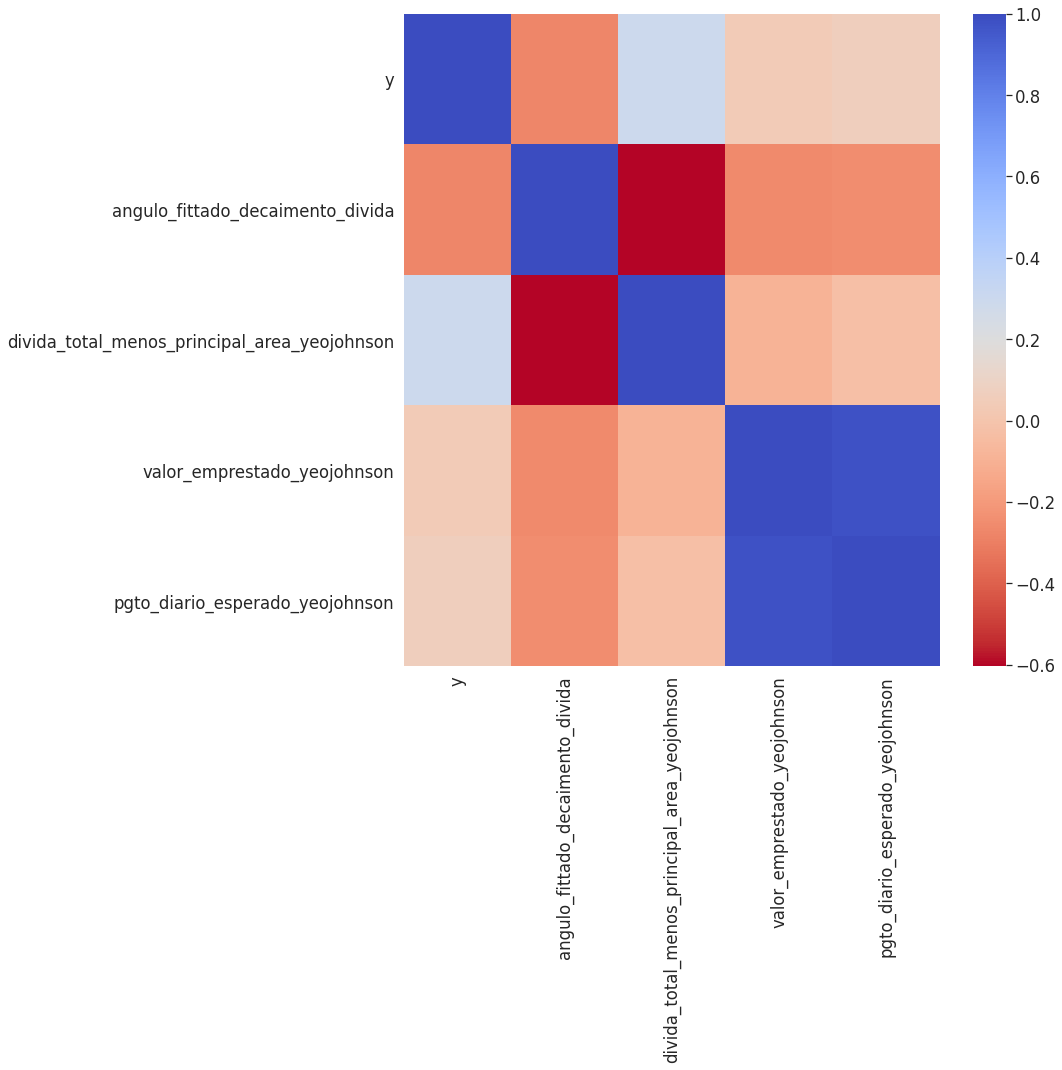

In [147]:
# Checking relation between attributes
numerical_cols = [cname for cname in df_constant_transformed.columns if df_constant_transformed[cname].dtype in ['int64', 'float64']]

cov_df_loan = df_constant_transformed[numerical_cols].corr()

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(ax=ax, data=cov_df_loan, cmap='coolwarm_r')

In [148]:
# pgto_diario_esperado and valor_emprestado seem to be highly correlated...

## 3. Encoding Categorical Attributes

In [150]:
df_constant_transformed.head()

,y,angulo_fittado_decaimento_divida,divida_total_menos_principal_area_yeojohnson,pagamento_diario_alto,pagamento_diario_baixo,amortizacao_diario_alto,amortizacao_diario_baixo,transacao_diaria_alto,transacao_diaria_baixo,divida_total_alto,...,Comercio,Educacao,"Industria, Construcao e Veiculos",Informatica,Moda e Esports,N/A,Saude,Servicos,valor_emprestado_yeojohnson,pgto_diario_esperado_yeojohnson
id,,,,,,,,,,,,,,,,,,,,,
6,0,1.628024,1.961158,1,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0.063227,0.163011
8,0,2.232980,-0.356976,0,1,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0.037281,0.136149
9,0,1.909969,-0.638575,1,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,1.697321,1.724273
11,0,1.665559,1.284546,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,-0.412766,-0.364297
12,0,2.205745,-0.382014,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0.136919,0.168556


In [151]:
categorical_cols = [cname for cname in df_constant_transformed.columns if df_constant_transformed[cname].dtype.name in ['category']]
categorical_cols

[]

In [152]:
for categorical_col in categorical_cols: 
    df_constant_transformed = pd.concat([df_constant_transformed, pd.get_dummies(df_constant_transformed[categorical_col])], axis=1)
    df_constant_transformed.drop(columns=categorical_col, inplace=True)

In [153]:
df_constant_transformed.columns

Index(['y', 'angulo_fittado_decaimento_divida',
       'divida_total_menos_principal_area_yeojohnson', 'pagamento_diario_alto',
       'pagamento_diario_baixo', 'amortizacao_diario_alto',
       'amortizacao_diario_baixo', 'transacao_diaria_alto',
       'transacao_diaria_baixo', 'divida_total_alto', 'divida_total_baixo',
       'angulo_esperado_alto', 'angulo_esperado_baixo', 'score_do_fit_alto',
       'score_do_fit_baixo', 'Alimentacao e Bebida', 'Comercio', 'Educacao',
       'Industria, Construcao e Veiculos', 'Informatica', 'Moda e Esports',
       'N/A', 'Saude', 'Servicos', 'valor_emprestado_yeojohnson',
       'pgto_diario_esperado_yeojohnson'],
      dtype='object')

## 4. Scalling

In [154]:
df_constant_scalled = df_constant_transformed.copy()
# StandardScale angulo_fittado_decaimento_divida, divida_total_menos_principal_area_yeojohnson

scalling_attributes = ['angulo_fittado_decaimento_divida', 'divida_total_menos_principal_area_yeojohnson']

In [155]:
df_constant_scalled['angulo_fittado_decaimento_divida'] = PowerTransformer().fit_transform(df_constant_scalled['angulo_fittado_decaimento_divida'].values.reshape(-1,1))
df_constant_scalled['divida_total_menos_principal_area_yeojohnson'] = StandardScaler().fit_transform(df_constant_scalled['divida_total_menos_principal_area_yeojohnson'].values.reshape(-1,1))

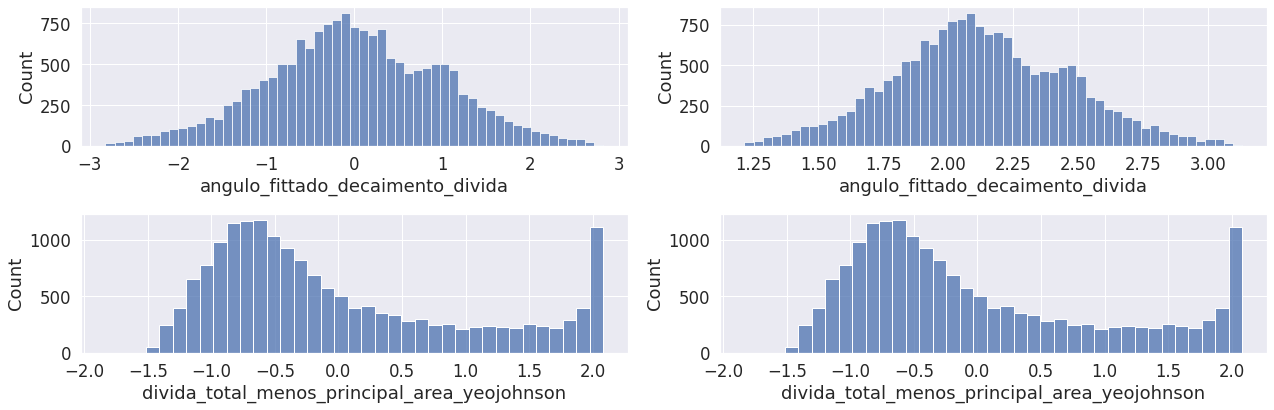

In [156]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,6))

for i, attribute in enumerate(scalling_attributes):
    sns.histplot(ax=ax[i,0], data=df_constant_scalled[attribute])
    sns.histplot(ax=ax[i,1], data=df_constant_transformed[attribute])    
    
fig.tight_layout(pad=1)

## 4. Imputting missing values

In [157]:
from sklearn.impute import SimpleImputer

# imputting missing values in case of some null parameter
imp = SimpleImputer(strategy="most_frequent")
tmp = imp.fit_transform(df_sampled)

## 4. Dealing with Unbalanced Data

In [158]:
df_sampled = df_constant_transformed.copy()

768 Defaults, 16576 not Default.


/home/rmcfe/Documents/Projects/stone-data-challenge/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


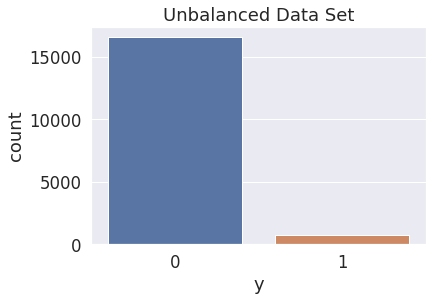

In [159]:
sns.countplot(df_sampled['y'])

plt.title("Unbalanced Data Set");

n_defaults = sum(df_sampled['y'] == 1)
n_not_defaults = sum(df_sampled['y'] == 0)

print(f"{n_defaults} Defaults, {n_not_defaults} not Default.")

### 4.1 Sampling the original dataset

#### It Is visible that the data set is unbalance. Some sampling tecniques (Undersampling and oversampling) can be applied to avoid some overffiting is classification models due to an unbalanced dataset. But before applying these tecniques, the original dataset must be preserved for testing. So, the models will be fitted with the a dataset that were exposed to some sampling tecnique and, afterwards, it will be tested with the original dataset.

In [160]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = df_sampled.drop('y', axis=1)
y = df_sampled['y']

stratified_fold = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

for train_index, test_index in stratified_fold.split(X, y):
    original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
    original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]
    
# Convert to array for the ml model
original_X_train = original_X_train.values
original_X_test = original_X_test.values
original_y_train = original_y_train.values
original_y_test = original_y_test.values

In [161]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17344 entries, 6 to 59443
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   y                                             17344 non-null  int64  
 1   angulo_fittado_decaimento_divida              17343 non-null  float64
 2   divida_total_menos_principal_area_yeojohnson  17344 non-null  float64
 3   pagamento_diario_alto                         17344 non-null  uint8  
 4   pagamento_diario_baixo                        17344 non-null  uint8  
 5   amortizacao_diario_alto                       17344 non-null  uint8  
 6   amortizacao_diario_baixo                      17344 non-null  uint8  
 7   transacao_diaria_alto                         17344 non-null  uint8  
 8   transacao_diaria_baixo                        17344 non-null  uint8  
 9   divida_total_alto                             17344 non-null 

### 4.2 UnderSampling

In [162]:
# shuffling the dataset
df_sampled.sample(n=df_sampled.shape[0], random_state=1)

default_df = df_sampled.loc[df_sampled['y'] == 1]

#number of default loans
default_amount = (df_sampled['y'] == 1).sum()

# select same number of non defaults
non_default_df = df_sampled.loc[df_sampled['y'] == 0][:default_amount]

balanced_df = pd.concat([default_df, non_default_df])

# Shuffle dataframe rows
balanced_df = balanced_df.sample(n=balanced_df.shape[0], random_state=1)

balanced_df.head()

,y,angulo_fittado_decaimento_divida,divida_total_menos_principal_area_yeojohnson,pagamento_diario_alto,pagamento_diario_baixo,amortizacao_diario_alto,amortizacao_diario_baixo,transacao_diaria_alto,transacao_diaria_baixo,divida_total_alto,...,Comercio,Educacao,"Industria, Construcao e Veiculos",Informatica,Moda e Esports,N/A,Saude,Servicos,valor_emprestado_yeojohnson,pgto_diario_esperado_yeojohnson
id,,,,,,,,,,,,,,,,,,,,,
4694,1,1.519822,1.947581,1,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,1.708062,1.747731
35601,1,1.363419,2.081922,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,-0.456920,-0.356942
19456,1,1.787262,1.541662,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,-0.031004,0.188980
8669,1,1.682551,1.855034,1,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,-0.089563,0.061594
1748,0,2.301131,1.877862,0,1,0,1,1,0,0,...,0,0,0,0,0,1,0,0,-0.734927,-0.538702


## Ml Models for the UnderSample Database

In [165]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


X = balanced_df.drop('y', axis=1)
y = balanced_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

Recall Score: 0.7095238095238096
Auc Score: 0.7743021346469623


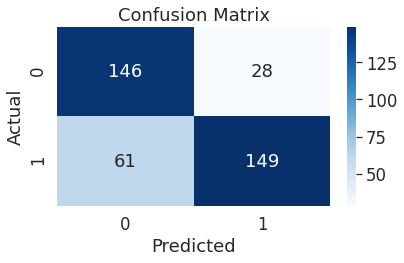

In [190]:
# Logistic Regression
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter': [300]}

log_grid_search = GridSearchCV(
    LogisticRegression(), log_reg_params,
    refit=True, n_jobs=-1)

log_grid_search.fit(X_train, y_train)
log_reg = log_grid_search.best_estimator_

y_pred = log_grid_search.predict(X_test)
confusion_matrix_plot(y_test, y_pred)

print(f"Recall Score: {recall_score(y_test, y_pred)}")
print(f"Auc Score: {roc_auc_score(y_test, y_pred)}")


plt.tight_layout()

In [192]:
log_reg.predict_proba(X_test)

array([[0.51835262, 0.48164738],
       [0.29503625, 0.70496375],
       [0.74102143, 0.25897857],
       [0.33999759, 0.66000241],
       [0.02747917, 0.97252083],
       [0.8110775 , 0.1889225 ],
       [0.03782996, 0.96217004],
       [0.04144677, 0.95855323],
       [0.96985922, 0.03014078],
       [0.67956889, 0.32043111],
       [0.58912487, 0.41087513],
       [0.82175243, 0.17824757],
       [0.15705079, 0.84294921],
       [0.88954715, 0.11045285],
       [0.66512013, 0.33487987],
       [0.54181416, 0.45818584],
       [0.36332595, 0.63667405],
       [0.68015041, 0.31984959],
       [0.4796665 , 0.5203335 ],
       [0.77990118, 0.22009882],
       [0.03666337, 0.96333663],
       [0.1739459 , 0.8260541 ],
       [0.78257527, 0.21742473],
       [0.17111641, 0.82888359],
       [0.50270066, 0.49729934],
       [0.72045776, 0.27954224],
       [0.05340352, 0.94659648],
       [0.01838853, 0.98161147],
       [0.0212733 , 0.9787267 ],
       [0.48776639, 0.51223361],
       [0.

## Random Forest

Best Parameters: RandomForestClassifier(max_depth=6, max_features=0.3, n_estimators=90,
                       random_state=1)

Recall Score: 0.6571428571428571
Auc Score: 0.7682266009852217
CPU times: user 939 ms, sys: 91.9 ms, total: 1.03 s
Wall time: 24.2 s


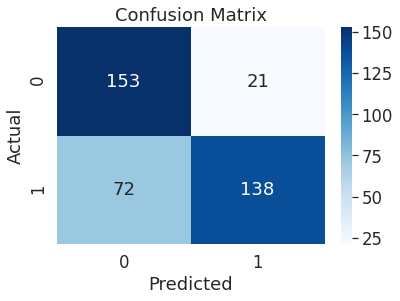

In [185]:
%%time
rf_params = {
    "n_estimators": [50, 70, 90, 110], 
    "max_depth": [4, 6, 8, 10, 12], 
    "max_features": [0.1, 0.2, 0.3],
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state = 1), 
    rf_params, n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
rf_best = rf_grid_search.best_estimator_

y_pred = rf_best.predict(X_test)
confusion_matrix_plot(y_test, y_pred)

print(f"Best Parameters: {rf_best}")
print()
print(f"Recall Score: {recall_score(y_test, y_pred)}")
print(f"Auc Score: {roc_auc_score(y_test, y_pred)}")

Recall Score: 0.671875
Auc Score: 0.7567139003257624


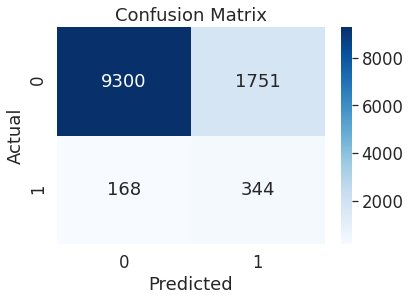

In [184]:
y_pred = rf_best.predict(original_X_train)
confusion_matrix_plot(original_y_train, y_pred)

print(f"Recall Score: {recall_score(original_y_train, y_pred)}")
print(f"Auc Score: {roc_auc_score(original_y_train, y_pred)}")

In [ ]:
#     original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
#     original_y_train, original_y_test